# <u>**Lab 4: 3D Reconstruction from two images with known internal parameters</u>**

In this lab you will learn how to triangulate the matching correspondences between two views of the same scene, by means of applying the Direct Linear Method (DLT). Then you will compute the camera matrices of these images given the Fundamental Matrix and the Intrinsic Matrix, and will evaluate your triangulation method on these camera matrices by estimating the reprojection error in the triangulation. 

The last two tasks will involve the computation of depth maps by local methods (SSD, NCC), with their evaluation, and the implementation of bilateral weights on this mapping. 

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [78]:
from IPython.display import display, HTML
import numpy as np
from numpy import linalg as LA
import cv2
import math
import sys
import random
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (19, 10)
from operator import itemgetter
from plotly import graph_objects as go
import copy
from tqdm import tqdm
from multiprocessing import Pool
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from time import time 
from functools import partial

import utils
from utils import homogeneous2euclidean, euclidean2homogeneous, projective2img, img2projective
import aux_code as aux

np.set_printoptions(precision=3)

# **1. Triangulation with the DLT method**

The first task is to implement the DLT method that will compute the 3D points corresponding to the matches of two images whose camera matrices are known. [See derivation of DLT here](https://www.cs.cmu.edu/~16385/s17/Slides/11.4_Triangulation.pdf)

![image](https://user-images.githubusercontent.com/8356912/151347636-c3332917-a7da-402e-9eb6-f39beb91591a.png)


<span style='color:Green'> - Create the function triangulate(x1, x2, P1, P2, imsize) that performs a triangulation with the homogeneous algebraic method (DLT)  </span>

The entries are (x1, x2, P1, P2, imsize), where:
- x1: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 1 reference frame 
- x2: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 2 reference frame.
- P1: Camera 1 matrix of shape (3,4)
- P2: Camera 2 matrix of shape (3,4)
- imsize: Iterable with shape (2,) with the image size

The function should return:
- X: array of shape (4, `n_points`), containing the Homogenous Coordinates of the points in 3D space.  

Test the triangulate function: use this code to validate that the function triangulate works properly

HINT: check numpy.linalg.svd

In [79]:
# Write here the method for DLT triangulation
def triangulate(x1, x2, P1, P2, imsize) -> np.ndarray:
    assert P1.shape == (3,4) == P2.shape
    assert x1.shape == x2.shape and x1.shape[0] == 3
    '''
    Your implementation here
    '''
       
    # Normalization --> Scale and translate so that both pixel coordinates are in the range [-1,1]
    x1 = x1/x1[2,:]
    x2 = x2/x2[2,:]

    nx = imsize[0]
    ny = imsize[1]

    H = [[2/nx,  0,     -1],
        [0,      2/ny,  -1],
        [0,      0,      1]]

    # normalize the points and the camera matrices
    x1 = H @ x1
    x2= H @ x2
    P1 = H @ P1
    P2 = H @ P2

    # create the A matrix
    
    X = []
    for i in range(x1.shape[1]):
        A = np.array([x1[0,i]*P1[2,:] - P1[0,:], 
                      x1[1,i]*P1[2,:] - P1[1,:],
                      x2[0,i]*P2[2,:] - P2[0,:],
                      x2[1,i]*P2[2,:] - P2[1,:]])
        U,D,Vt = LA.svd(A)
        X.append(Vt[-1,:])
        
    return np.asarray(X).T
    raise NotImplementedError("You must implement this, don't forget")
    

#### Test the triangulation function with two Cameras and some random points. The average triangulation error should be lower than 10<sup>-8</sup>


In [80]:
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1                            # Cam1 Canonical Camera Matrix

angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])     # Cam2 Rotation_z(theta[deg])
t = np.array([[1.1, .1, .2]])                         # Cam2 Translation(x[m], y[m], z[m]) 
P2 = np.concatenate((R, t.T), axis=1)

n_points = 20                                        # Number of data samples (points) (x,y,z)
X_eucl = np.random.uniform(0, 1, (3,n_points))       # Random points in 3D space on world reference frame
X_eucl[2,:] += 3                                     # Make points fit into the camera frame 
X = euclidean2homogeneous(X_eucl)                    # 

# Obtain the camera coordinates (rays) from each point.
x_proj1 = P1 @ X                                     # Project to Cam1 image coordinates (x,y,z)->[x_c1:y_c1:z_c1]
x_proj2 = P2 @ X                                     # Project to Cam2 image coordinates (x,y,z)->[x_c2:y_c2:z_c2]

# Estimate the 3D points (you need to create this function)
X_trian = triangulate(x_proj1, x_proj2, P1, P2, ((2,2)))
assert X_trian.shape == (4, n_points)

# Evaluation: compute the reprojection error
X_eucl_pred = homogeneous2euclidean(X_trian)
X_eucl = homogeneous2euclidean(X)
errors = np.linalg.norm(X_eucl - X_eucl_pred, axis=0)
avg_error = np.mean(errors)
print(f"Average triangulation error: {avg_error:.2e}[m]")
assert avg_error < 1e-8, "Something might be wrong here"


Average triangulation error: 1.84e-15[m]


#### We will plot the results to check that the triangulated values are close to the ground truth

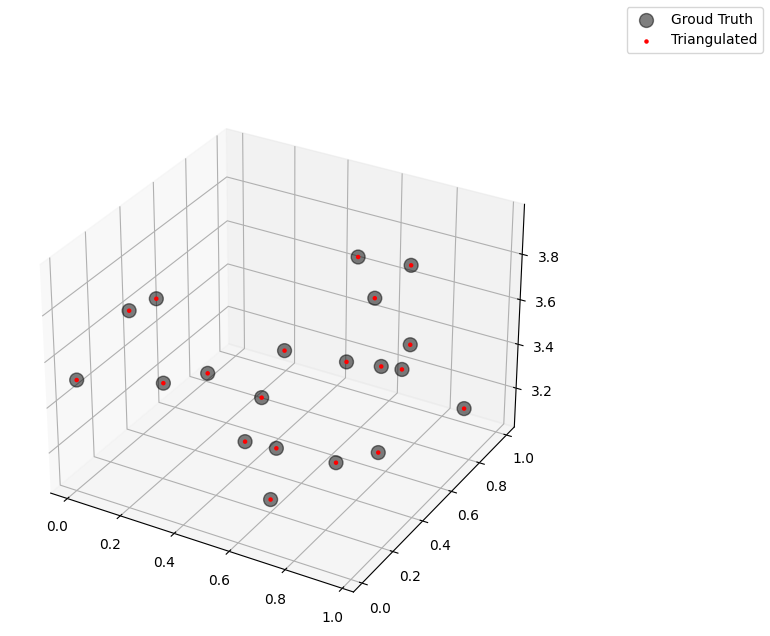

In [81]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection='3d')
utils.draw_points(X_eucl.T, ax=ax, c="k", alpha=0.5, s=100, depthshade=True, label="Groud Truth")
utils.draw_points(X_eucl_pred.T, ax=ax, c="r", alpha=1, s=5, depthshade=True, label="Triangulated")
fig.legend()

In [82]:
fig = go.Figure(layout=dict(height=400, width=550))
fig.add_trace(go.Scatter3d(x=X_eucl[0,:], y=X_eucl[1,:], z=X_eucl[2,:], mode='markers', marker=dict(size=6, color="black", opacity=0.5), name='Ground Truth'))
fig.add_trace(go.Scatter3d(x=X_eucl_pred[0,:], y=X_eucl_pred[1,:], z=X_eucl_pred[2,:], mode='markers', marker=dict(size=2, color="red", opacity=1), name='Triangulated'))
fig.show()

# 2. **[Reconstruction](https://www.cs.cmu.edu/~16385/s17/Slides/12.5_Reconstruction.pdf) from two views**

The goal of this section is to estimate the 3D reconstruction from two views in a practical situation where the image correspondences contain outliers. 

To acomplish this you have to:

1. Find a set of point correspondences between the two images. This correspondences will contain noise/outliers, therefore we cannot use [Epipolar Geometry](https://www.cs.cmu.edu/~16385/s17/Slides/12.1_Epipolar_Geometry.pdf) to calculate the [Essential Matrix](https://www.cs.cmu.edu/~16385/s17/Slides/12.2_Essential_Matrix.pdf), but we can find the Fundamental Matrix. 
2. Estimate the [Fundamental Matrix](https://www.cs.cmu.edu/~16385/s17/Slides/12.3_Fundamental_Matrix.pdf) relating the two camera images. Since correspondances are noisy we will use the [8-point Algorithm](https://www.cs.cmu.edu/~16385/s17/Slides/12.4_8Point_Algorithm.pdf) in combination with the RANSAC algorithm, to find a good estimate of $F$.
3. Calculate the Essential Matrix from the Fundamental Matrix
4. Find the two Camera Matrices.
## 2.1 Estimate the image matches


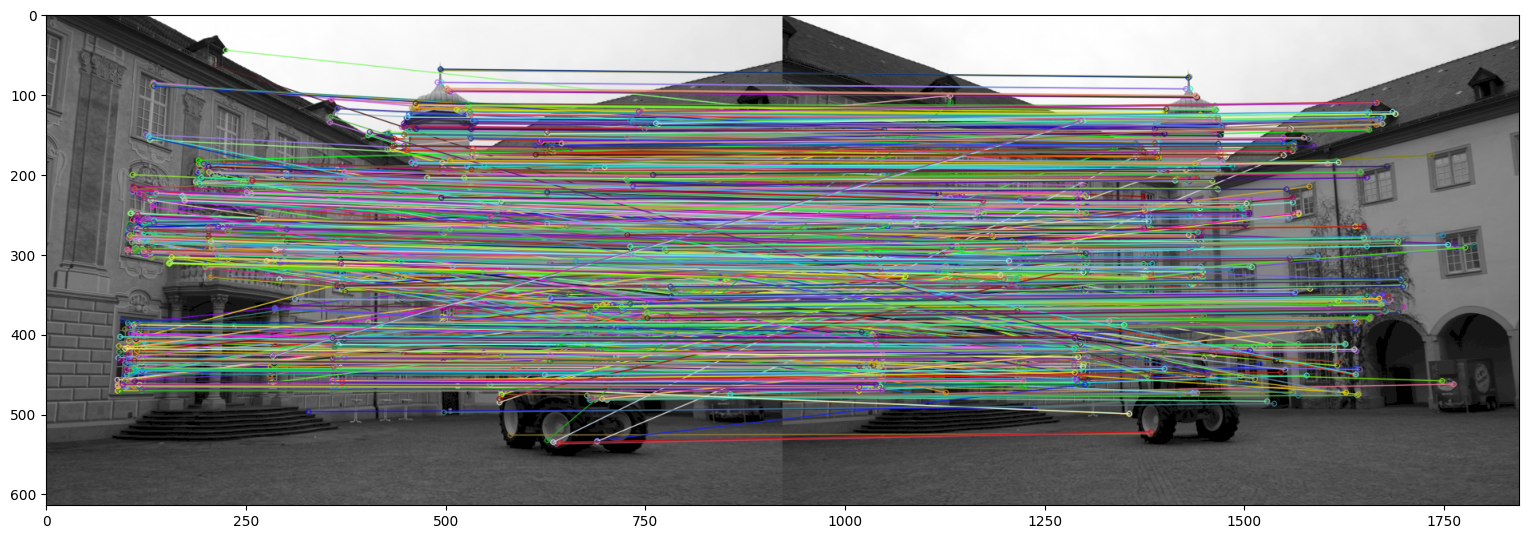

In [83]:
# Read images
img1 = cv2.imread('Data/0001_s.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/0002_s.png',cv2.IMREAD_GRAYSCALE)
h, w = img1.shape

# Initiate ORB detector
orb = cv2.ORB_create(3000)
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# Keypoint matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

# Show "good" matches
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig = plt.figure()
plt.imshow(img_12)
plt.show()

## 2.2 Estimate the Fundamental Matrix
To find the Fundamental Matrix $F$ we will use the 8-point algorithm. However, using only 8 correspondances might lead to bad estimates of $F$. To find a robust estimate we will use the RANSAC algorithm. In simple words the algorithm samples randomly 8 correspondances and estimates $F_{estimated}$ for these samples, then it evaluates how well does $F_{estimated}$ fit the rest of the data. We repreat this process until a limit of iterations is reached and select the best estimated $F$.  

(Code is provided)

3291 684


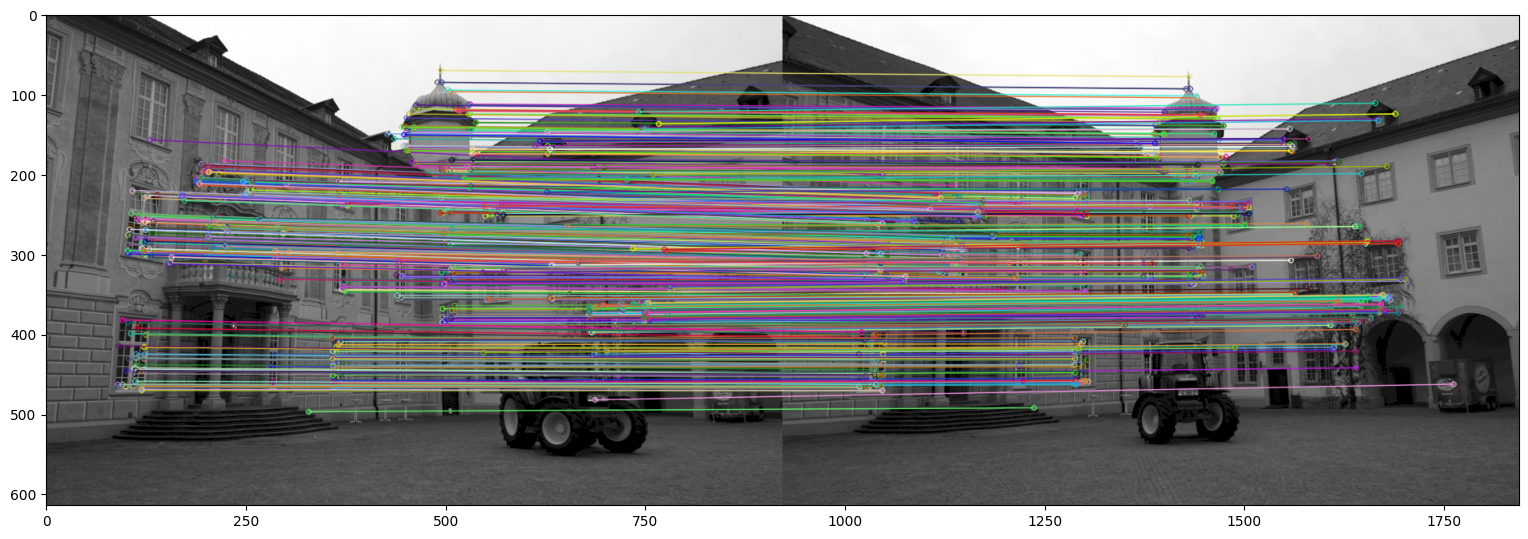

In [84]:
# Robust estimation of the fundamental matrix #
points1 = []
points2 = []
for m in matches:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

F, indices_inlier_matches = aux.Ransac_fundamental_matrix(points1, points2, 1, 5000)
inlier_matches = itemgetter(*indices_inlier_matches)(matches)

img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig = plt.figure()
plt.imshow(img_12)
plt.show()

## 2.3 Estimate the Essential Matrix
<span style='color:Green'> - Compute the [Essential matrix](https://www.cs.cmu.edu/~16385/s17/Slides/12.2_Essential_Matrix.pdf) from the Fundamental matrix </span>

In [85]:
# Camera calibration matrix
K = np.array([[2362.12, 0, 1520.69], [0, 2366.12, 1006.81], [0, 0, 1]])
scale = 0.3;
H = np.array([[scale, 0, 0], [ 0, scale, 0], [0, 0, 1]])
K = H @ K;

def essential_from_fundamental(K, F):
    #raise NotImplementedError()
    E = K.T @ F @ K
    print("The Rank of the essential matrix is = ", np.linalg.matrix_rank(E))
    return E


E = essential_from_fundamental(K, F)

The Rank of the essential matrix is =  2


## 2.4. Estimate the Camera Matrices from the Essential Matrix
<span style='color:Green'> - Estimate the camera projection matrices. Assuming the first Camera has a cannonical matrix you will obtain four possible Camera Matrices for the second camera, two rotations and two translations.</span>

 - Please explain how do you obtain this estimates, not what algorithm or methodology you used to obtain them. i.e., What system of equations are you solving?
 - Why do you obtain 4 solutions? Why not only one?

HINT: Once you estimate the rotations $R$ and translation $T$ of the second camera matrix, you may get as results improper rotations: $|R| = -1$ i.e., $R \in O(3), R \notin SO(3)$. <span style='color:Green'> (Why do you think this happens?) </span> In that case you should make the rotation proper by avoiding the unwanted reflexion (multiply by -1 so $|R| = 1$): e.g.,
  
      if det(R) < 0:  
          R = -R

In [86]:
# # camera projection matrix for the first camera --> assuming it has a cannonical matrix
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1
P1 = K @ P1

# # four possible matrices for the second camera
# two possible rotations -> R1 = UWtVt and R2 = UWVt
# two possible translations -> t1 = u3 and t2 = -u3

W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
U, D, Vt = LA.svd(E)
R1 = U @ W @ Vt
R2 = U @ W.T @ Vt

#remove unwanted reflections
if LA.det(R1) < 0:
    R1 = -R1

if LA.det(R2) < 0:
    R2 = -R2

#get the translation
u3 = U[:,-1]

#compute the second camera projection matrix
Pc2 = [None, None, None, None];
Pc2[0] = K @ np.column_stack((R1, u3))
Pc2[1] = K @ np.column_stack((R1, -u3))
Pc2[2] = K @ np.column_stack((R2, u3))
Pc2[3] = K @ np.column_stack((R2, -u3))

Lets visualize the 4 possible Camera positions and orientations, in relation to Camera 1 

(-1.5, 1.5)

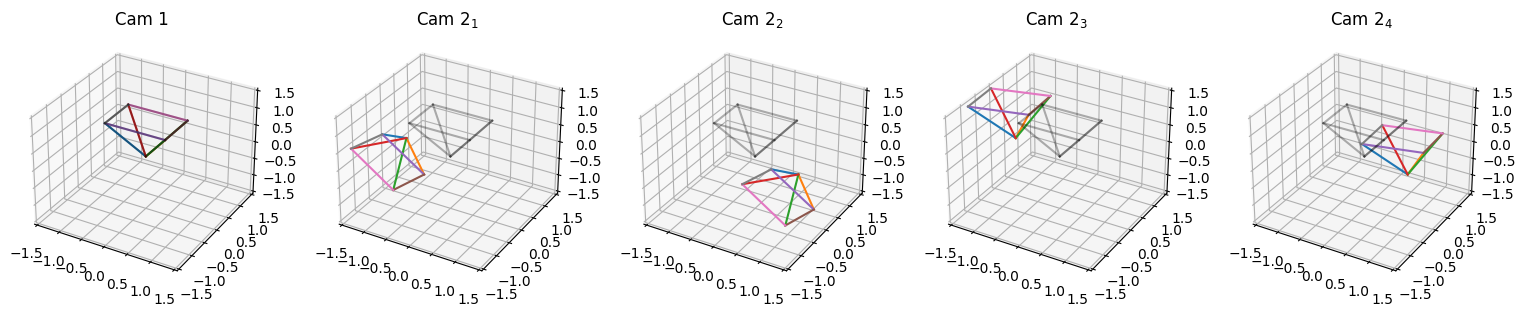

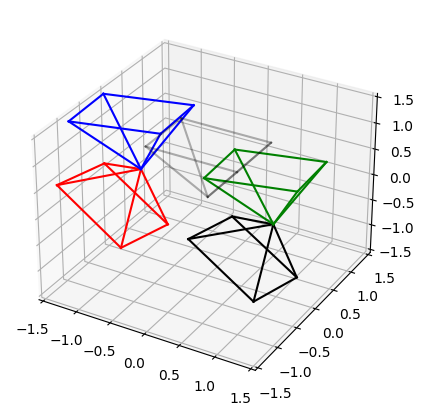

In [87]:
# plot the first camera and the four possible solutions for the second figure:
fig = plt.figure()
axs = [fig.add_subplot(1,5,i+1, projection='3d') for i in range(5)]
titles = ["Cam 1"] + [r"Cam $2_{%s}$" % int(i+1) for i in range(len(Pc2)) ]

low_lim, up_lim = -1.5, 1.5
for ax, title, P in zip(axs, titles, [P1] + Pc2):
    utils.plot_camera(P,w,h, 1, ax=ax)
    utils.plot_camera(P1,w,h, 1, ax=ax, alpha=0.3, color="k") # Show Cam1 for reference
    ax.set_title(title)
    ax.set_xlim(low_lim, up_lim)
    ax.set_ylim(low_lim, up_lim)
    ax.set_zlim(low_lim, up_lim)
    
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
for P, color in zip(Pc2, ['r','k','b','g']):
    utils.plot_camera(P,w,h, 1, ax=ax, color=color)
utils.plot_camera(P1,w,h, 1, ax=ax, alpha=0.3, color="k") # Show Cam1 for reference
ax.set_xlim(low_lim, up_lim)
ax.set_ylim(low_lim, up_lim)
ax.set_zlim(low_lim, up_lim)

<span style='color:Green'> - Triangulate the correspondances and select the "optimal" camera, how do you select it ?</span>
   

(4, 684)
-155.79851777299072
False
(4, 684)
155.79851777299072
False
(4, 684)
387.37214874859086
False
(4, 684)
-387.37214874859086
False


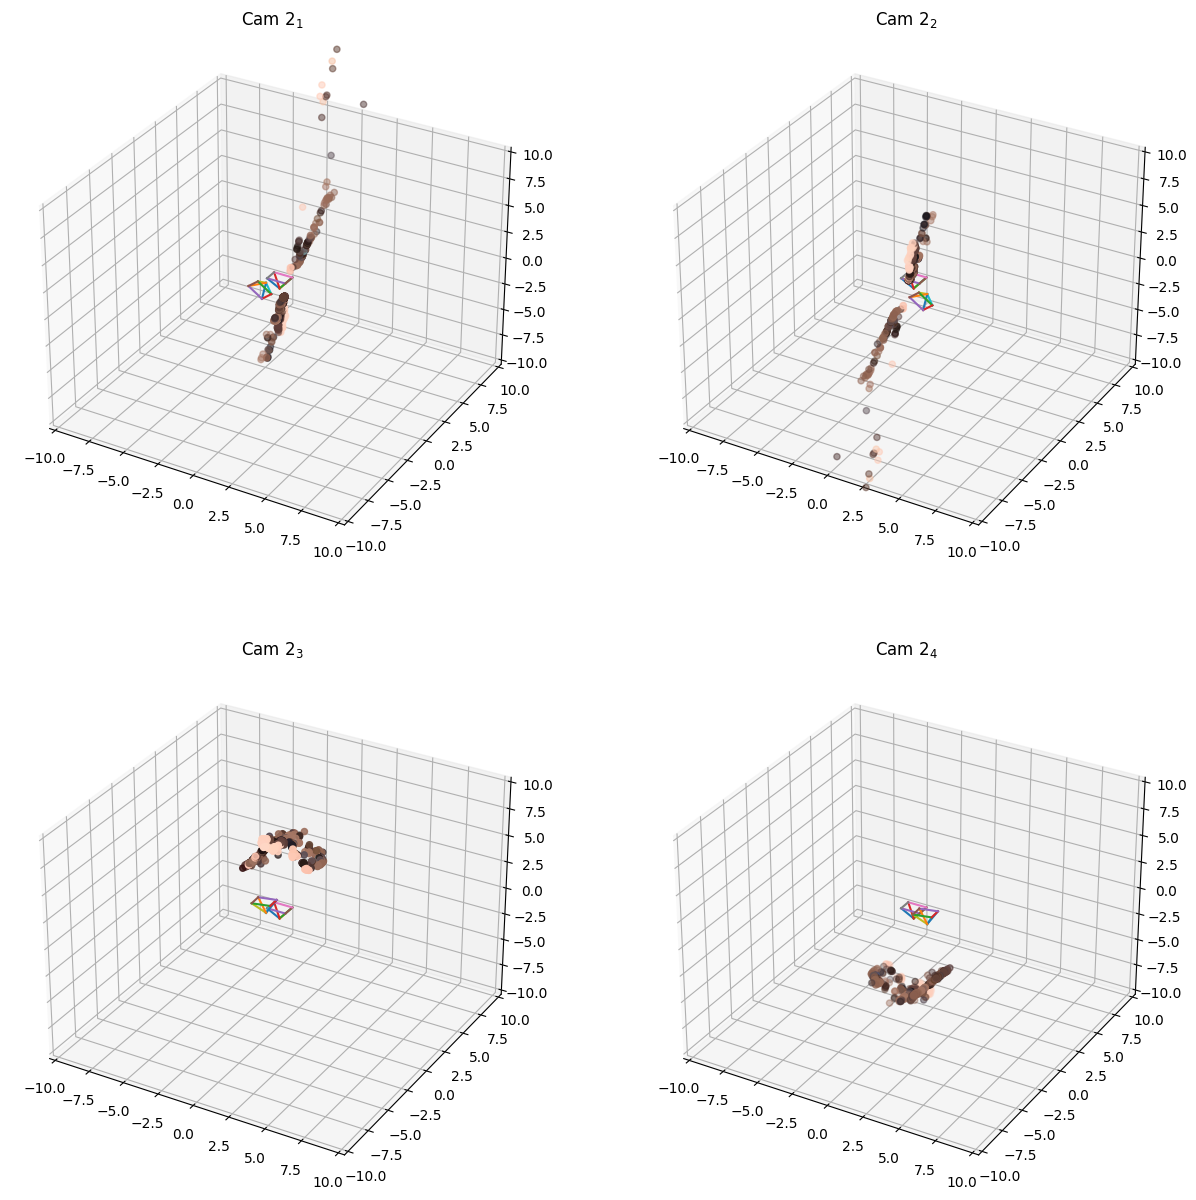

In [95]:
img1 = cv2.imread('Data/0000_s.png',cv2.IMREAD_UNCHANGED)


# Obtain the inlier points projective coordinates for Camera 1 and 2 #complete
x1 = points1[:,indices_inlier_matches] #complete
x2 = points2[:,indices_inlier_matches] #complete

# Prepare figure 
fig = plt.figure(figsize=(15,15))
axs = [fig.add_subplot(2,2,i+1, projection='3d') for i in range(4)]

# Variable for optimal camera
P2_selected = None

low_lim, up_lim = -10, 10
for i, ax, P2 in zip(range(len(Pc2)), axs, Pc2):

    # Estimate by triangulization the 3D coordinates of the matches
    X_pred = triangulate(x1, x2, P1, P2, [w, h])
    X_eucl = homogeneous2euclidean(X_pred)

    # Render the 3D point cloud
    x_img = np.transpose(x1[:2]).astype(int)
    rgb_txt = (img1[x_img[:,1], x_img[:,0]])/255
    utils.draw_points(X_eucl.T, color=rgb_txt, ax=ax)
    utils.plot_camera(P1,w,h,1, ax=ax)
    utils.plot_camera(P2,w,h,1, ax=ax)
    ax.set_title(r"Cam $2_{%d}$" % (i+1))
    ax.set_xlim(low_lim, up_lim)
    ax.set_ylim(low_lim, up_lim)
    ax.set_zlim(low_lim, up_lim)
    
    # Select the best camera using some metric  --> only one of the 4 options for camera 2 makes sense. The reconstructed points have to be in front of both cameras

    #compute the reconstructed points ?????????????????????? NOT SURE IF IT IS CORRECT
    rp1 = P1.T @ X_eucl
    rp2 = P2.T @ X_eucl 

    print(rp1.shape)
    print(rp1[0,0])

    #ensure that the reconstructed point is in front of both cameras --> z component is positive
    some_metric = np.all(rp1[2] > 0) and np.all(rp2[2] > 0) # NOT WORKING ????????????????????????????''''''
    print(some_metric)
    if some_metric:
        P2_selected = P2
        print("The camera selected is the camera number ", i+1)

# From now own P2 will be the camera you selected
P2 = P2_selected

## 2.5 3D Visualization
 We will visualize the 3D points for the selected camera with an interactive plot so that you can see the surfaces reconstructed in 3D

In [89]:
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()
# Estimate by triangulization the 3D coordinates of the matches
X_pred = triangulate(x1, x2, P1, P2, [w, h])
X_eucl = X_pred/X_pred[-1,:]
points3d = X_eucl[:3].T
fig = go.Figure(layout=dict(height=400, width=550))
points3d = X_eucl[:3].T
fig.add_trace(go.Scatter3d(x=points3d[:,0], y=points3d[:,1], z=points3d[:,2],mode='markers',name='3d points',marker=dict(color=rgb_txt, size=2)))
fig.show()
#### And these are the corresponding points in 2D 

In [ ]:
img_with_selected_points = copy.deepcopy(img1)
img_with_selected_points[x_img[:,1], x_img[:,0]] = [255,0,0]
plt.figure(figsize = (80,40))
plt.imshow(img_with_selected_points)

## 2.6 Reprojection Error

Once you selected a Camera, analyze the error of reprojecting the 3D space back to image coordinates. 

<span style='color:Green'>- Compute the reprojection errors  </span>
<span style='color:Green'>- Plot the histogram of reprojection errors, </span>
<span style='color:Green'>- Plot the mean reprojection error  </span>

In [ ]:
def reprojection_errors(x1, x2, P1, P2, X):
    """
    - x1: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 1 reference frame 
    - x2: array of shape (3, `n_points`), containing matching points in projective coordinates from Camera 2 reference frame.
    - P1: Camera 1 matrix
    - P2: Camera 2 matrix 
    - X: (4, `n_points`) homogenous coordinates of points in 3D space
    Compute the reprojection error from `X` to each of the camera's projective coordinates
    @return: (cam1_errors, cam2_errors)
    """
    
    '''
    Your implementation here
    '''
    raise NotImplementedError("You must implement this, don't forget")

    return cam1_errors, cam2_errors

def plot_error_stats(cam1_errors, cam2_errors):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    
    ax1.hist(cam1_errors, color='c')
    ax1.grid(axis='y', alpha=0.2)
    ax1.set_xlabel("Reprojection Error Cam 1 [What units am I?]")
    ax2.hist(cam2_errors, color='k')
    ax2.grid(axis='y', alpha=0.2)
    ax2.set_xlabel("Reprojection Error Cam 2 [What units am I?]")


# Get projections with selected Camera 
X_pred = ...

cam1_errors, cam2_errors = reprojection_errors(x1, x2, P1, P2, X_pred)

plot_error_stats(cam1_errors, cam2_errors)

# **3. Depth map computation using local methods**

## 3.1 Vectorization (hint)

Vectorization is important to get efficient implementations that will allow you to run experiments in a reasonable amount of time

We will show you an example dummy computation using a naive implementation, a parallelized implementation and a vectorized implementation to see the importance of an efficient implementation and some ideas that you may reuse in the lab. This is just an example and there are different ways to vectorize, so I would suggest **reading about vectorization in python and finding your way.**


In [ ]:
def add_row_calculation(row, N, height, width, padding, window_size):
    count = 0.
    N = window_size**2*(height-2*padding)*(width-2*padding)
    for column in range(padding, width-padding):
        for i in range(window_size):
            for j in range(window_size):
                count += (left_img[row+i-padding, column+j-padding] -
                           right_img[row+i-padding, column+j-padding]) / N
    return count 

def dummy_computation(left_img, right_img, window_size):
    assert (window_size%2==1)
    assert (left_img.shape == right_img.shape)
    height, width = left_img.shape[0], left_img.shape[1]
    padding = window_size//2
    count = 0.
    N = window_size**2*(height-2*padding)*(width-2*padding)
    for row in tqdm(range(padding, height-padding)):
        count += add_row_calculation(row, N=N, height=height, width=width, padding=padding, window_size=window_size)
    return count
    
def dummy_computation_parallelized(left_img, right_img, window_size, num_process=12):
    assert (window_size%2==1)
    assert (left_img.shape == right_img.shape)
    height, width = left_img.shape[0], left_img.shape[1]
    padding = window_size//2
    count = 0.
    N = window_size**2*(height-2*padding)*(width-2*padding)
    with Pool(num_process) as pool:
        r = pool.map(partial(add_row_calculation, N=N, height=height, width=width, padding=padding, window_size=window_size),
                     range(padding, height-padding))
    return np.sum(r)

def dummy_computation_vectorized(left_img, right_img, window_size):
    left_view = sliding_window_view(left_img, (window_size, window_size))
    right_view = sliding_window_view(right_img, (window_size, window_size))
    return np.average(left_view - right_view)
    
left_img = cv2.imread("Data/scene1.row3.col3.ppm", cv2.IMREAD_GRAYSCALE).astype(np.float64)
right_img = cv2.imread("Data/scene1.row3.col4.ppm", cv2.IMREAD_GRAYSCALE).astype(np.float64)
window_size = 3
num_process = 12
t1 = time()
print("Naive method result: \t\t", dummy_computation(left_img, right_img, window_size))
t2 = time()
# parallel_computation = DummyComputationParallized(left_img, right_img, window_size)
# print("Parallelized method result: \t\t", parallel_computation.run())
print("Parallelized method result: \t", dummy_computation_parallelized(left_img, right_img, window_size, num_process))
t3 = time()
print("Vectorized method result: \t", dummy_computation_vectorized(left_img, right_img, window_size))
t4 = time()
print(f"Naive method time: \t\t{t2-t1} seconds")
print(f"Parallelized method time: \t{t3-t2} seconds")
print(f"Vectorized method time: \t{t4-t3} seconds")

## 3.2 Disparity between a pair of rectified images

<span style='color:Green'> - Write a function called 'stereo_computation' that computes the disparity between a pair of rectified images </span>

Computational Efficiency is not a requirement but a plus.

![image](https://user-images.githubusercontent.com/8356912/151308788-854ad073-48b3-495a-af4c-dea99f4343d9.png)

**Optional:** You can also compute the depth map knowing *a priori* the focal length and baseline of the camera configuration (source: https://vision.middlebury.edu/stereo/data/scenes2014/)

In [ ]:
def stereo_computation(left_img, right_img, min_disparity, max_disparity, win_size, method, **method_kwargs):
    """
    :param left_img: 
    :param right_img: 
    :param min_disparity: 
    :param max_disparity: 
    :param win_size: 
    :param method: 
    :param method_kwargs
    :return: 
    """

## 3.3 Sum of Squared Differences Cost
__Data images: 'scene1.row3.col3.ppm','scene1.row3.col4.ppm'  
Disparity ground truth: 'truedisp.row3.col3.pgm'__

In this part we ask to implement only the SSD cost


<span style='color:Green'> - Evaluate the results changing the window size (e.g. 3x3, 9x9, 21x21,31x31) and the Mean Square Error (MSE). Comment the results.  </span>

 **Note 1**: Use grayscale images  
 
 **Note 2**: For this first set of images use 0 as minimum disparity and 16 as the the maximum one.

![image](https://user-images.githubusercontent.com/8356912/151308710-679e9b2c-8dfc-48da-8378-a844b10ef4f7.png)

## 3.4 Normalized  Cross Correlation Cost

<span style='color:Green'> - Complete the previous function by adding the implementation of the NCC cost. </span>

<span style='color:Green'>  Evaluate the results changing the window size (e.g. 3x3, 9x9, 21x21,31x31). Comment the results. </span>



## 3.5 Apply to facade images

Data images: '0001_rectified_s.png','0002_rectified_s.png'

<span style='color:Green'> - Test the functions implemented in the previous section with the facade images. Try different matching costs and window sizes and comment the results. </span>
    
Notice that in this new data the minimum and maximum disparities may change.

## 3.6 Adaptive support weights


<span style='color:Green'> - Modify the 'stereo_computation' so that you can use adaptive support weights considering both **proximity** and **similarity**</span>

- Use the original [Exponential](https://ieeexplore.ieee.org/document/1597121#:~:text=Abstract%3A%20We%20present%20a%20new,to%20reduce%20the%20image%20ambiguity.) filters and [Bilateral](https://www.ipol.im/pub/art/2015/123/) Filtering. How are they different?
- How are the support weights adaptive? Plot the support weights for exemplary cases that illustrate the adaptive nature.
- Implement the support weights for color and black and white images. What similarity metric for black and white can you use? 
- Make a small comparison of the effect of the support weights parameters, and compare them to the previous results.
   
Reference paper: Yoon and Kweon, "Adaptive Support-Weight Approach for Correspondence Search", IEEE PAMI 2006

![image](https://user-images.githubusercontent.com/8356912/151323058-04124700-7c77-46bc-8b25-6ac1473300ce.png)


# **Optional Tasks**


## Optional 1:  Depth computation with Plane Sweeping

<span style='color:Green'>  Implement the plane sweeping method explained in class. You can implemented naively or with the computational efficiency details explained on the paper</span>
 
 "Given a plane in space, it is possible to project both images onto
it using projective texture mapping. If the plane is located
at the same depth as the recorded scene, pixels from both
images should be consistent." [Multi-Resolution Real-Time Stereo on Commodity Graphics Hardware](https://people.inf.ethz.ch/pomarc/pubs/YangCVPR03.pdf)

- Be clear about what information from the cameras and scene is required
- Implement the algorithm for two Cameras. Test it on the Middlebury images. Compare quantitatively this method and the previously developed ones for depth estimates with respect to the ground truth depth.
- What changes you will have to make to process unrectified images? No need to implement them.

## Optional 2:  New view synthesis using view morphing

In this task you are asked to implement part of the new view synthesis method presented in the following paper: S. Seitz, and C. Dyer, View morphing, Proc. ACM SIGGRAPH 1996.

You will use a pair of rectified stereo images (no need for prewarping and postwarping stages) and their corresponding ground truth disparities (folder "new_view"). Remember to take into account occlusions as explained in the lab session. Once done you can apply the code to the another pair of rectified images provided in the material and use the estimated disparities with previous methods.

![new_views_morph](https://user-images.githubusercontent.com/8356912/151237907-8944e3d2-f84d-4707-a63c-357f005b4823.gif)


## Optional 3:  Depth map fusion review

This task is intended to bridge the concepts from novel and traditional applications. You must not implement any code but you are asked to review 2 papers:

- [B. Curless and M. Levoy. A Volumetric Method for Building Complex Models from Range Images. In Proc. SIGGRAPH, 1996](https://graphics.stanford.edu/papers/volrange/volrange.pdf).
- [RoutedFusion: Learning Real-time Depth Map Fusion Silvan Weder, Johannes L. Schönberger, Marc Pollefeys, Martin R. Oswald May 2020](https://www.silvanweder.com/publications/routed-fusion/)

You should provide a brief report Max 3 pages, less is preffered, where you make a detailed comparison between the two methods.
- Pay special attention to what concepts are shared between both approaches along the entire processing pipeline.
- What role play NN based function approximators in the entire processing pipeline of the second paper.How do they relate to the first approach? 

![image](https://user-images.githubusercontent.com/8356912/151363747-ae8ab96a-8eb9-4b56-b797-2eddf72f3e9c.png)

